In [1]:
import numpy as np
import keras
import keras.backend as k
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications import mobilenet
from keras.models import load_model
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Set Random Seeds to Constant For Sake of Reproducibility 
import numpy as np
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED']= '0'
np.random.seed(0)
rn.seed(0)
tf.set_random_seed(0)

In [3]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
train_path = r'E:\SkinCancerDetection\Train'
valid_path = r'E:\SkinCancerDetection\Valid'
test_path = r'E:\SkinCancerDetection\Test'
model_path = r'E:\SkinCancerDetection\ModelData'

In [7]:
train_dataGen = ImageDataGenerator(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.15,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function=mobilenet.preprocess_input
                )
valid_dataGen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)
test_dataGen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

In [8]:
train_batches = train_dataGen.flow_from_directory(directory=train_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=10)
valid_batches = valid_dataGen.flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=10)
test_batches = test_dataGen.flow_from_directory(directory=test_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=460, shuffle=False)

Found 3640 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [9]:
mobilenet_model = mobilenet.MobileNet(input_shape=(224, 224, 3))

In [55]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [10]:
x = mobilenet_model.layers[-4].output
x = Flatten()(x)
prediction = Dense(1, activation='sigmoid')(x)
model = Model(input = mobilenet_model.input, output=prediction)

C:\Users\BHARATHAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [11]:
for layer in model.layers[:-23]:
    layer.trainable = False
print(model.layers[-14])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [12]:
model.load_weights(r'E:\SkinCancerDetection\ModelData\MobileNet_weights.hdf5')
checkpoint=ModelCheckpoint(filepath=r'E:\SkinCancerDetection\ModelData\MobileNet_weights.hdf5', monitor='val_acc', verbose=0,
                 save_best_only=True, save_weights_only=False,
                 mode='max', period=1)
callbacks_list = [checkpoint]


In [ ]:
model.compile(optimizer=Adam(lr=0.000005), loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(generator=train_batches, steps_per_epoch=364, epochs=4, callbacks=callbacks_list, validation_data=valid_batches, validation_steps=46)

Epoch 1/4
 21/364 [>.............................] - ETA: 1683s - loss: 0.1025 - acc: 0.9571

In [75]:
model.save('skinCancerMobileNet_model_1.hdf5')
print(callbacks_list)
model.save_weights('MobileNet_weights.hdf5')

In [37]:
from tensorflow.python.keras._impl.keras.utils.generic_utils import CustomObjectScope
from tensorflow.python.keras._impl.keras.applications import mobilenet
with CustomObjectScope({'relu6': mobilenet.relu6,'DepthwiseConv2D': mobilenet.DepthwiseConv2D}):
    m = load_model(r'E:\SkinCancerDetection\ModelData\skinCancerMobileNet_model_1.h5')

In [70]:
train_data = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['Benign', 'Malignant'], class_mode='binary', batch_size=3640)
imgs, labels = next(train_data)

Found 3640 images belonging to 2 classes.


In [42]:
test_imgs, test_labels = next(test_batches)

In [71]:
predictions = m.predict(imgs, verbose = 1)

3640/3640 [==============================] - 947s   


In [72]:
cm = confusion_matrix(labels, np.round(predictions))

Confusion matrix, without normalization
[[1576  244]
 [   9 1811]]


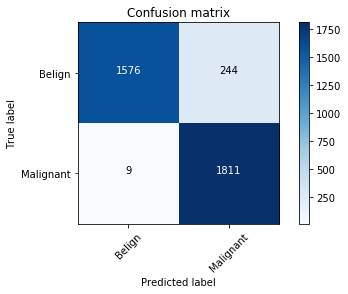

In [73]:
plot_confusion_matrix(cm, classes=['Belign', 'Malignant'])

In [2]:
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
import os
frm_b = r'E:\Data\Cropped\Benign'
frm_m = r'E:\Data\Cropped\Malignant'
tbw = None
tbh = None
tmw = None
tmh = None

for i in os.listdir(frm_b):
    img = image.load_img(frm_b + '\\' + i)
    arr = image.img_to_array(img)
    print(i)
    if tmw == None or tmw > arr.shape[0]:
        tmw = arr.shape[0]
    if tmh == None or tmh < arr.shape[0]:
        tmh = arr.shape[0]

ISIC_0000000.jpeg
ISIC_0000001.jpeg
ISIC_0000003.jpeg
ISIC_0000005.jpeg
ISIC_0000006.jpeg
ISIC_0000007.jpeg
ISIC_0000008.jpeg
ISIC_0000009.jpeg
ISIC_0000010.jpeg
ISIC_0000011.jpeg
ISIC_0000012.jpeg
ISIC_0000014.jpeg
ISIC_0000015.jpeg
ISIC_0000016.jpeg
ISIC_0000017.jpeg
ISIC_0000018.jpeg
ISIC_0000019.jpeg
ISIC_0000020.jpeg
ISIC_0000021.jpeg
ISIC_0000023.jpeg
ISIC_0000024.jpeg
ISIC_0000025.jpeg
ISIC_0000027.jpeg
ISIC_0000028.jpeg
ISIC_0000032.jpeg
ISIC_0000033.jpeg
ISIC_0000034.jpeg
ISIC_0000037.jpeg
ISIC_0000038.jpeg
ISIC_0000039.jpeg
ISIC_0000041.jpeg
ISIC_0000042.jpeg
ISIC_0000044.jpeg
ISIC_0000045.jpeg
ISIC_0000047.jpeg
ISIC_0000048.jpeg
ISIC_0000050.jpeg
ISIC_0000051.jpeg
ISIC_0000052.jpeg
ISIC_0000053.jpeg
ISIC_0000055.jpeg
ISIC_0000057.jpeg
ISIC_0000058.jpeg
ISIC_0000059.jpeg
ISIC_0000060.jpeg
ISIC_0000061.jpeg
ISIC_0000062.jpeg
ISIC_0000063.jpeg
ISIC_0000064.jpeg
ISIC_0000065.jpeg
ISIC_0000066.jpeg
ISIC_0000067.jpeg
ISIC_0000068.jpeg
ISIC_0000069.jpeg
ISIC_0000071.jpeg
ISIC_00000

ISIC_0000615.jpeg
ISIC_0000616.jpeg
ISIC_0000617.jpeg
ISIC_0000618.jpeg
ISIC_0000619.jpeg
ISIC_0000620.jpeg
ISIC_0000621.jpeg
ISIC_0000622.jpeg
ISIC_0000623.jpeg
ISIC_0000624.jpeg
ISIC_0000625.jpeg
ISIC_0000626.jpeg
ISIC_0000627.jpeg
ISIC_0000628.jpeg
ISIC_0000629.jpeg
ISIC_0000630.jpeg
ISIC_0000631.jpeg
ISIC_0000632.jpeg
ISIC_0000633.jpeg
ISIC_0000634.jpeg
ISIC_0000635.jpeg
ISIC_0000636.jpeg
ISIC_0000637.jpeg
ISIC_0000638.jpeg
ISIC_0000639.jpeg
ISIC_0000640.jpeg
ISIC_0000641.jpeg
ISIC_0000642.jpeg
ISIC_0000643.jpeg
ISIC_0000644.jpeg
ISIC_0000645.jpeg
ISIC_0000646.jpeg
ISIC_0000647.jpeg
ISIC_0000648.jpeg
ISIC_0000649.jpeg
ISIC_0000650.jpeg
ISIC_0000651.jpeg
ISIC_0000652.jpeg
ISIC_0000653.jpeg
ISIC_0000654.jpeg
ISIC_0000655.jpeg
ISIC_0000656.jpeg
ISIC_0000657.jpeg
ISIC_0000658.jpeg
ISIC_0000659.jpeg
ISIC_0000660.jpeg
ISIC_0000661.jpeg
ISIC_0000662.jpeg
ISIC_0000663.jpeg
ISIC_0000664.jpeg
ISIC_0000665.jpeg
ISIC_0000666.jpeg
ISIC_0000667.jpeg
ISIC_0000668.jpeg
ISIC_0000669.jpeg
ISIC_00006

ISIC_0001071.jpeg
ISIC_0001072.jpeg
ISIC_0001073.jpeg
ISIC_0001074.jpeg
ISIC_0001075.jpeg
ISIC_0001076.jpeg
ISIC_0001077.jpeg
ISIC_0001078.jpeg
ISIC_0001079.jpeg
ISIC_0001080.jpeg
ISIC_0001081.jpeg
ISIC_0001082.jpeg
ISIC_0001083.jpeg
ISIC_0001084.jpeg
ISIC_0001085.jpeg
ISIC_0001086.jpeg
ISIC_0001087.jpeg
ISIC_0001088.jpeg
ISIC_0001089.jpeg
ISIC_0001090.jpeg
ISIC_0001091.jpeg
ISIC_0001092.jpeg
ISIC_0001093.jpeg
ISIC_0001094.jpeg
ISIC_0001095.jpeg
ISIC_0001096.jpeg
ISIC_0001097.jpeg
ISIC_0001098.jpeg
ISIC_0001099.jpeg
ISIC_0001104.jpeg
ISIC_0001107.jpeg
ISIC_0001109.jpeg
ISIC_0001111.jpeg
ISIC_0001113.jpeg
ISIC_0001114.jpeg
ISIC_0001115.jpeg
ISIC_0001117.jpeg
ISIC_0001122.jpeg
ISIC_0001123.jpeg
ISIC_0001129.jpeg
ISIC_0001130.jpeg
ISIC_0001136.jpeg
ISIC_0001139.jpeg
ISIC_0001144.jpeg
ISIC_0001145.jpeg
ISIC_0001146.jpeg
ISIC_0001147.jpeg
ISIC_0001150.jpeg
ISIC_0001153.jpeg
ISIC_0001155.jpeg
ISIC_0001156.jpeg
ISIC_0001158.jpeg
ISIC_0001160.jpeg
ISIC_0001161.jpeg
ISIC_0001162.jpeg
ISIC_00011

ISIC_0001564.jpeg
ISIC_0001565.jpeg
ISIC_0001566.jpeg
ISIC_0001567.jpeg
ISIC_0001568.jpeg
ISIC_0001569.jpeg
ISIC_0001570.jpeg
ISIC_0001571.jpeg
ISIC_0001572.jpeg
ISIC_0001573.jpeg
ISIC_0001574.jpeg
ISIC_0001575.jpeg
ISIC_0001576.jpeg
ISIC_0001577.jpeg
ISIC_0001578.jpeg
ISIC_0001579.jpeg
ISIC_0001580.jpeg
ISIC_0001581.jpeg
ISIC_0001582.jpeg
ISIC_0001583.jpeg
ISIC_0001584.jpeg
ISIC_0001585.jpeg
ISIC_0001586.jpeg
ISIC_0001587.jpeg
ISIC_0001588.jpeg
ISIC_0001589.jpeg
ISIC_0001590.jpeg
ISIC_0001591.jpeg
ISIC_0001592.jpeg
ISIC_0001593.jpeg
ISIC_0001594.jpeg
ISIC_0001595.jpeg
ISIC_0001596.jpeg
ISIC_0001597.jpeg
ISIC_0001598.jpeg
ISIC_0001599.jpeg
ISIC_0001600.jpeg
ISIC_0001601.jpeg
ISIC_0001602.jpeg
ISIC_0001603.jpeg
ISIC_0001604.jpeg
ISIC_0001605.jpeg
ISIC_0001606.jpeg
ISIC_0001607.jpeg
ISIC_0001608.jpeg
ISIC_0001609.jpeg
ISIC_0001610.jpeg
ISIC_0001611.jpeg
ISIC_0001612.jpeg
ISIC_0001613.jpeg
ISIC_0001614.jpeg
ISIC_0001615.jpeg
ISIC_0001616.jpeg
ISIC_0001617.jpeg
ISIC_0001618.jpeg
ISIC_00016

ISIC_0002034.jpeg
ISIC_0002035.jpeg
ISIC_0002036.jpeg
ISIC_0002037.jpeg
ISIC_0002038.jpeg
ISIC_0002039.jpeg
ISIC_0002040.jpeg
ISIC_0002041.jpeg
ISIC_0002042.jpeg
ISIC_0002043.jpeg
ISIC_0002044.jpeg
ISIC_0002045.jpeg
ISIC_0002046.jpeg
ISIC_0002047.jpeg
ISIC_0002048.jpeg
ISIC_0002049.jpeg
ISIC_0002050.jpeg
ISIC_0002051.jpeg
ISIC_0002052.jpeg
ISIC_0002053.jpeg
ISIC_0002054.jpeg
ISIC_0002055.jpeg
ISIC_0002056.jpeg
ISIC_0002057.jpeg
ISIC_0002058.jpeg
ISIC_0002059.jpeg
ISIC_0002060.jpeg
ISIC_0002061.jpeg
ISIC_0002062.jpeg
ISIC_0002063.jpeg
ISIC_0002064.jpeg
ISIC_0002065.jpeg
ISIC_0002066.jpeg
ISIC_0002067.jpeg
ISIC_0002068.jpeg
ISIC_0002069.jpeg
ISIC_0002070.jpeg
ISIC_0002071.jpeg
ISIC_0002072.jpeg
ISIC_0002073.jpeg
ISIC_0002074.jpeg
ISIC_0002075.jpeg
ISIC_0002076.jpeg
ISIC_0002077.jpeg
ISIC_0002078.jpeg
ISIC_0002079.jpeg
ISIC_0002080.jpeg
ISIC_0002081.jpeg
ISIC_0002082.jpeg
ISIC_0002083.jpeg
ISIC_0002084.jpeg
ISIC_0002087.jpeg
ISIC_0002100.jpeg
ISIC_0002101.jpeg
ISIC_0002102.jpeg
ISIC_00021

In [ ]:
for i in os.listdir(frm_m):
    img = image.load_img(frm_m + '\\' + i)
    arr = image.img_to_array(img)
    print(i)
    if tbw == None or tbw > arr.shape[0]:
        tbw = arr.shape[0]
    if tbh == None or tbh < arr.shape[0]:
        tbh = arr.shape[0]

In [ ]:
print(tbw, 'x', tbh)
print(tmw, 'x', tmh)